## Simple Feed Forward Neural Network
- Try two-layer simple neural network

In [2]:
import numpy as np

class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        # He initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2/input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2/hidden_size)
        self.b2 = np.zeros((1, output_size))
        
        # Store intermediate values for each layer, used in backpropagation
        self.z1 = None
        self.h1 = None
        self.z2 = None
        self.output = None
    
    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def sigmoid_derivative(self, x):
        """Sigmoid derivative"""
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def softmax(self, x):
        """Numerically stable softmax implementation"""
        x_shifted = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x_shifted)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        """Forward propagation"""
        # First layer: Input layer -> Hidden layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.h1 = self.sigmoid(self.z1)
        
        # Second layer: Hidden layer -> Output layer
        self.z2 = np.dot(self.h1, self.W2) + self.b2
        self.output = self.softmax(self.z2)
        
        return self.output
    
    def compute_loss(self, y_indices, y_pred):
        """Compute sparse categorical cross-entropy loss"""
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        batch_size = y_indices.shape[0]
        correct_probs = y_pred[range(batch_size), y_indices]
        return -np.mean(np.log(correct_probs))
    
    def backward(self, X, y_indices, learning_rate):
        """Backward propagation"""
        batch_size = X.shape[0]
        
        # Create one-hot encoding of targets
        y = np.zeros((batch_size, self.W2.shape[1]))
        y[range(batch_size), y_indices] = 1
        
        # Output layer error (combined derivative of softmax and cross-entropy loss)
        d_output = self.output - y
        
        # Gradients from hidden layer to output layer
        d_W2 = np.dot(self.h1.T, d_output) / batch_size
        d_b2 = np.sum(d_output, axis=0, keepdims=True) / batch_size
        
        # Gradients from input layer to hidden layer
        d_h1 = np.dot(d_output, self.W2.T)
        d_z1 = d_h1 * self.sigmoid_derivative(self.z1)
        d_W1 = np.dot(X.T, d_z1) / batch_size
        d_b1 = np.sum(d_z1, axis=0, keepdims=True) / batch_size
        
        # Update parameters
        self.W2 -= learning_rate * d_W2
        self.b2 -= learning_rate * d_b2
        self.W1 -= learning_rate * d_W1
        self.b1 -= learning_rate * d_b1
    
    def predict(self, X):
        """Predict classes"""
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)
    
    def train(self, X_train, y_train, X_val, y_val, epochs, learning_rate, batch_size=32):
        """Train the model"""
        train_losses = []
        val_losses = []
        
        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(len(X_train))
            
            # Mini-batch training
            for start_idx in range(0, len(X_train), batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                X_batch = X_train[batch_idx]
                y_batch = y_train[batch_idx]
                
                # Forward and backward propagation
                self.forward(X_batch)
                self.backward(X_batch, y_batch, learning_rate)
            
            # Calculate training and validation losses
            train_pred = self.forward(X_train)
            train_loss = self.compute_loss(y_train, train_pred)
            train_losses.append(train_loss)
            
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_losses.append(val_loss)
            
            if epoch % 10 == 0:
                train_acc = np.mean(self.predict(X_train) == y_train)
                val_acc = np.mean(self.predict(X_val) == y_val)
                print(f"Epoch {epoch}/{epochs}")
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        return train_losses, val_losses

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

def load_mnist(test_size=0.2, val_size=0.2):
    """
    Load and preprocess MNIST dataset
    
    Parameters:
    - test_size: proportion of test set
    - val_size: proportion of validation set (split from training set)
    
    Returns:
    - (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    # Load MNIST dataset
    print("Loading MNIST dataset...")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    
    # Convert data to float32 to save memory
    X = X.astype('float32')
    
    # Normalize pixel values to [0,1] range
    X = X / 255.0
    
    # Convert labels to integers
    y = y.astype('int32')
    
    # First split out the test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=42, 
        stratify=y
    )
    
    # Split validation set from remaining data
    train_val_split = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=train_val_split,
        random_state=42,
        stratify=y_temp
    )
    
    print(f"Train set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def create_batches(X, y, batch_size):
    """
    Create data batches
    """
    indices = np.random.permutation(len(X))
    for start_idx in range(0, len(X), batch_size):
        batch_idx = indices[start_idx:start_idx + batch_size]
        yield X[batch_idx], y[batch_idx]

In [ ]:
# load dataset

X_train, X_val, X_test, y_train, y_val, y_test = load_mnist()

Loading MNIST dataset...


/home/novoland/myenv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Train set: (42000, 784)
Validation set: (14000, 784)
Test set: (14000, 784)


In [ ]:
from utils import MnistDataloader

# Create data loaders


In [5]:
# model initialization
model = SimpleNN(input_size=784, hidden_size=128, output_size=10)

# train the model
train_losses, val_losses = model.train(
    X_train, y_train,
    X_val, y_val,
    epochs=100,
    learning_rate=0.1,
    batch_size=32
)

# predict on test set
predictions = model.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 0/100
Train Loss: 0.3597, Train Acc: 0.8984
Val Loss: 0.3629, Val Acc: 0.8993
Epoch 10/100
Train Loss: 0.1433, Train Acc: 0.9586
Val Loss: 0.1670, Val Acc: 0.9494
Epoch 20/100
Train Loss: 0.0811, Train Acc: 0.9774
Val Loss: 0.1176, Val Acc: 0.9645
Epoch 30/100
Train Loss: 0.0539, Train Acc: 0.9865
Val Loss: 0.0996, Val Acc: 0.9702
Epoch 40/100
Train Loss: 0.0385, Train Acc: 0.9914
Val Loss: 0.0915, Val Acc: 0.9724
Epoch 50/100
Train Loss: 0.0279, Train Acc: 0.9952
Val Loss: 0.0874, Val Acc: 0.9739
Epoch 60/100
Train Loss: 0.0209, Train Acc: 0.9972
Val Loss: 0.0838, Val Acc: 0.9750
Epoch 70/100
Train Loss: 0.0163, Train Acc: 0.9983
Val Loss: 0.0831, Val Acc: 0.9754
Epoch 80/100
Train Loss: 0.0128, Train Acc: 0.9991
Val Loss: 0.0825, Val Acc: 0.9758
Epoch 90/100
Train Loss: 0.0104, Train Acc: 0.9995
Val Loss: 0.0836, Val Acc: 0.9754
Test Accuracy: 0.9761


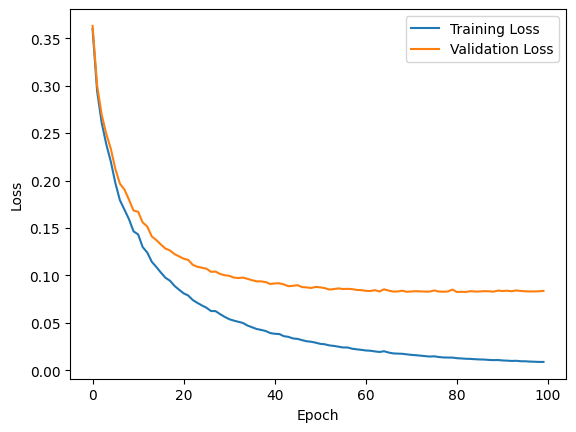

In [6]:
# plotting the training and validation loss

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [7]:
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

class ModelEvaluator:
    def __init__(self, model):
        self.model = model
    
    def compute_metrics(self, X_test, y_test):
        """Compute all evaluation metrics"""
        # Get prediction probabilities and classes
        y_pred_proba = self.model.forward(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Calculate precision, recall, and F1 scores
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
        
        # Calculate specificity for each class
        n_classes = y_pred_proba.shape[1]
        specificity = []
        for i in range(n_classes):
            tn = np.sum((y_test != i) & (y_pred != i))
            fp = np.sum((y_test != i) & (y_pred == i))
            specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        
        # Calculate ROC and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        # Calculate ROC curve and AUC for each class
        for i in range(n_classes):
            # Treat current class as positive, others as negative
            y_true_binary = (y_test == i).astype(int)
            y_score = y_pred_proba[:, i]
            
            fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score)
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        return {
            'confusion_matrix': conf_matrix,
            'precision': precision,
            'recall': recall,  # Same as sensitivity
            'f1': f1,
            'specificity': specificity,
            'support': support,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
    
    def plot_confusion_matrix(self, conf_matrix):
        """Plot confusion matrix heatmap"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    def plot_roc_curves(self, fpr, tpr, roc_auc):
        """Plot ROC curves"""
        plt.figure(figsize=(10, 8))
        
        # Plot ROC curve for each class
        for i in range(len(roc_auc)):
            plt.plot(
                fpr[i], 
                tpr[i], 
                label=f'Class {i} (AUC = {roc_auc[i]:.2f})'
            )
        
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for Each Class')
        plt.legend(loc="lower right")
        plt.show()
    
    def evaluate_and_plot(self, X_test, y_test):
        """Complete evaluation process"""
        # Calculate all metrics
        metrics = self.compute_metrics(X_test, y_test)
        
        # Print all evaluation metrics
        print("\nMetrics for each class:")
        for i in range(len(metrics['precision'])):
            print(f"\nMetrics for Class {i}:")
            print(f"Precision: {metrics['precision'][i]:.4f}")
            print(f"Recall/Sensitivity: {metrics['recall'][i]:.4f}")
            print(f"F1 Score: {metrics['f1'][i]:.4f}")
            print(f"Specificity: {metrics['specificity'][i]:.4f}")
            print(f"AUC: {metrics['roc_auc'][i]:.4f}")
            print(f"Support (sample count): {metrics['support'][i]}")
        
        # Plot confusion matrix
        print("\nConfusion Matrix:")
        self.plot_confusion_matrix(metrics['confusion_matrix'])
        
        # Plot ROC curves
        print("\nROC Curves:")
        self.plot_roc_curves(
            metrics['fpr'],
            metrics['tpr'],
            metrics['roc_auc']
        )
        
        return metrics


Metrics for each class:

Metrics for Class 0:
Precision: 0.9771
Recall/Sensitivity: 0.9899
F1 Score: 0.9835
Specificity: 0.9975
AUC: 0.9998
Support (sample count): 1381

Metrics for Class 1:
Precision: 0.9854
Recall/Sensitivity: 0.9873
F1 Score: 0.9864
Specificity: 0.9981
AUC: 0.9998
Support (sample count): 1575

Metrics for Class 2:
Precision: 0.9757
Recall/Sensitivity: 0.9750
F1 Score: 0.9753
Specificity: 0.9973
AUC: 0.9996
Support (sample count): 1398

Metrics for Class 3:
Precision: 0.9687
Recall/Sensitivity: 0.9755
F1 Score: 0.9721
Specificity: 0.9964
AUC: 0.9995
Support (sample count): 1428

Metrics for Class 4:
Precision: 0.9779
Recall/Sensitivity: 0.9729
F1 Score: 0.9754
Specificity: 0.9976
AUC: 0.9995
Support (sample count): 1365

Metrics for Class 5:
Precision: 0.9791
Recall/Sensitivity: 0.9644
F1 Score: 0.9717
Specificity: 0.9980
AUC: 0.9995
Support (sample count): 1263

Metrics for Class 6:
Precision: 0.9776
Recall/Sensitivity: 0.9818
F1 Score: 0.9797
Specificity: 0.9975
A

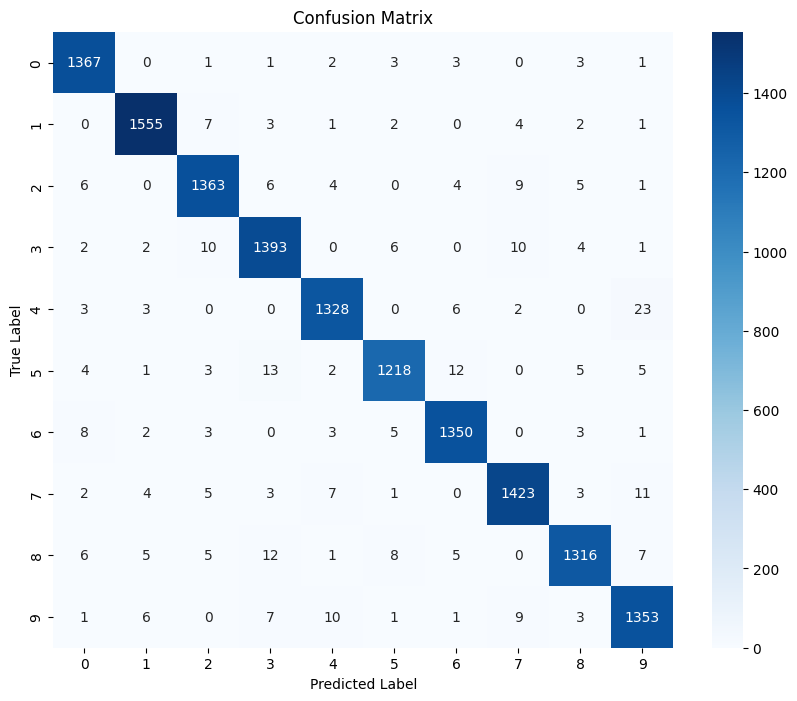


ROC Curves:


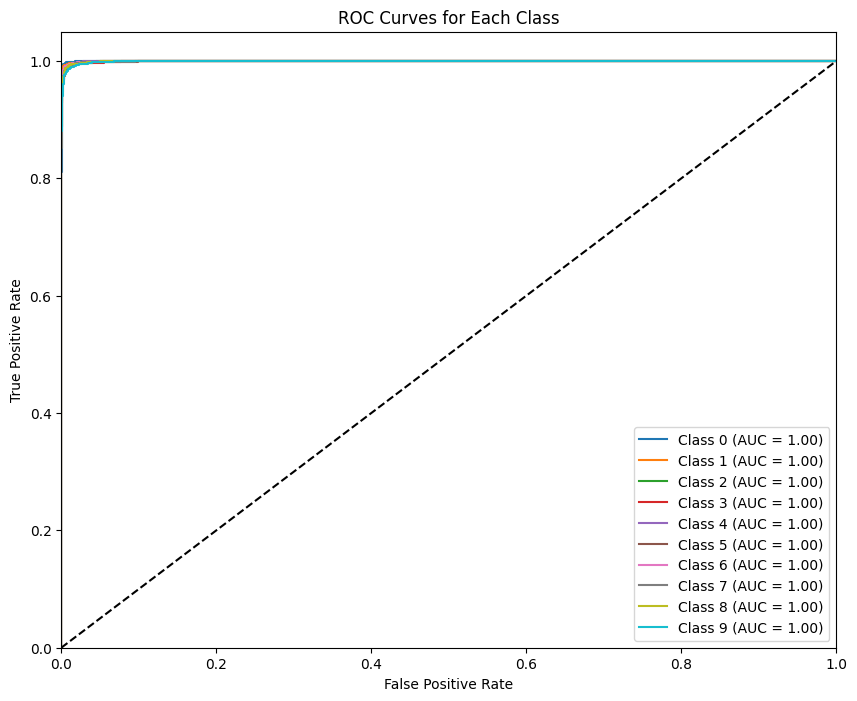

In [8]:

evaluator = ModelEvaluator(model)

metrics = evaluator.evaluate_and_plot(X_test, y_test)

conf_matrix = metrics['confusion_matrix']
roc_auc_scores = metrics['roc_auc']